# 🏗️ Exercício 3 – Placa 2D com PINN

Este notebook resolve o problema de uma placa bidimensional sob regime de elasticidade linear, utilizando **Physics-Informed Neural Networks (PINN)** com a biblioteca **PyTorch**.

### Problema:
Considera-se uma placa quadrada \( L = 1 \), com condições de contorno aplicadas conforme indicado no enunciado. O objetivo é encontrar os deslocamentos \( u(x,y) \) e \( v(x,y) \).

### Equações da Elasticidade Plana (sem forças volumétricas):
\[
\mu \nabla^2 \mathbf{u} + (\lambda + \mu) \nabla (\nabla \cdot \mathbf{u}) = 0
\]

Com \( \lambda, \mu \) sendo os parâmetros de Lame, obtidos a partir do módulo de Young \( E \) e do coeficiente de Poisson \( \nu \).

- \( E = 1 \), \( \nu = 0.3 \)


Época 0, Perda: 2.572860e-02
Época 500, Perda: 3.056149e-06
Época 1000, Perda: 4.849381e-07
Época 1500, Perda: 2.348104e-07
Época 2000, Perda: 1.485199e-07
Época 2500, Perda: 1.013494e-07
Época 3000, Perda: 7.338990e-08
Época 3500, Perda: 5.477180e-08
Época 4000, Perda: 1.156549e-06
Época 4500, Perda: 3.118038e-08


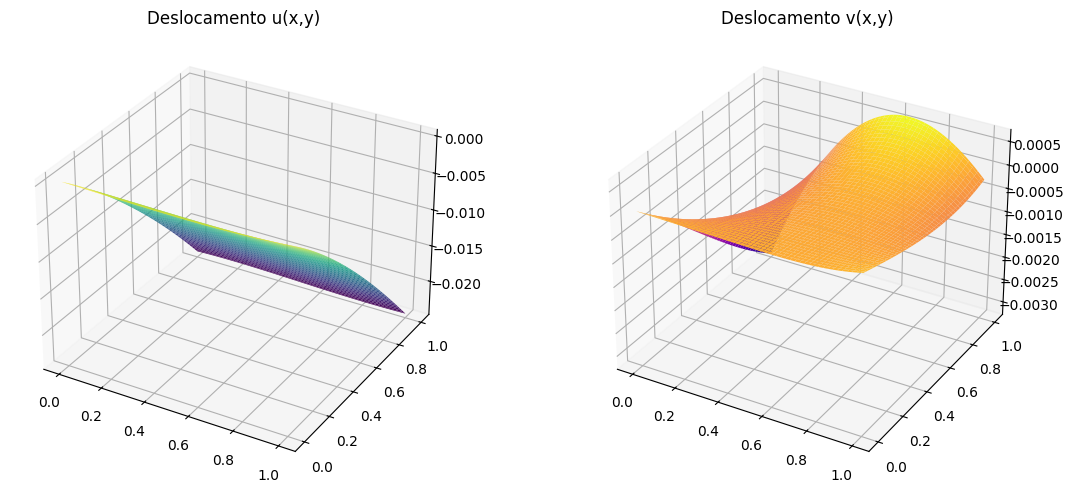

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 🟢 Parâmetros do problema
E = 1.0  # Módulo de Young
nu = 0.3  # Poisson
mu = E / (2 * (1 + nu))
lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))

# 🟢 Rede Neural PINN
class RedePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rede = nn.Sequential(
            nn.Linear(2, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.rede(x)

# 🟢 Função de perda com condições de contorno

def perda_pde_bc(modelo, pontos_interior, pontos_contorno):
    x = pontos_interior[:, 0:1].clone().detach().requires_grad_(True)
    y = pontos_interior[:, 1:2].clone().detach().requires_grad_(True)
    entrada = torch.cat([x, y], dim=1)
    u_v = modelo(entrada)
    u = u_v[:, 0:1]
    v = u_v[:, 1:2]

    # Derivadas
    grad_u = torch.autograd.grad(u, entrada, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    grad_v = torch.autograd.grad(v, entrada, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]
    v_x = grad_v[:, 0:1]
    v_y = grad_v[:, 1:2]

    # Tensões
    eps_xx = u_x
    eps_yy = v_y
    eps_xy = 0.5 * (u_y + v_x)

    sigma_xx = lmbda * (eps_xx + eps_yy) + 2 * mu * eps_xx
    sigma_yy = lmbda * (eps_xx + eps_yy) + 2 * mu * eps_yy
    sigma_xy = 2 * mu * eps_xy

    sigma_xx_x = torch.autograd.grad(sigma_xx, x, grad_outputs=torch.ones_like(sigma_xx), create_graph=True)[0]
    sigma_xy_y = torch.autograd.grad(sigma_xy, y, grad_outputs=torch.ones_like(sigma_xy), create_graph=True)[0]
    eq1 = sigma_xx_x + sigma_xy_y

    sigma_yy_y = torch.autograd.grad(sigma_yy, y, grad_outputs=torch.ones_like(sigma_yy), create_graph=True)[0]
    sigma_xy_x = torch.autograd.grad(sigma_xy, x, grad_outputs=torch.ones_like(sigma_xy), create_graph=True)[0]
    eq2 = sigma_yy_y + sigma_xy_x

    loss_pde = torch.mean(eq1**2) + torch.mean(eq2**2)

    # 🟢 Condições de contorno simples (deslocamento nulo em y=0)
    x_bc = pontos_contorno[:, 0:1].clone().detach()
    y_bc = pontos_contorno[:, 1:2].clone().detach()
    entrada_bc = torch.cat([x_bc, y_bc], dim=1)
    u_v_bc = modelo(entrada_bc)
    u_bc = u_v_bc[:, 0:1]
    v_bc = u_v_bc[:, 1:2]

    # Exemplo: deslocamento nulo em y = 0
    mask = (y_bc == 0).float()
    loss_bc = torch.mean((u_bc * mask)**2 + (v_bc * mask)**2)

    return loss_pde + loss_bc

# 🟢 Treinamento
modelo = RedePINN()
otim = torch.optim.Adam(modelo.parameters(), lr=0.001)

N_interior = 2000
N_bc = 400

pontos_interior = torch.rand(N_interior, 2)
pontos_contorno = torch.rand(N_bc, 2)
pontos_contorno[:, 1] = torch.where(torch.rand(N_bc) > 0.5, torch.zeros(N_bc), torch.ones(N_bc))  # y=0 ou y=1

for epoca in range(5000):
    otim.zero_grad()
    perda = perda_pde_bc(modelo, pontos_interior, pontos_contorno)
    perda.backward()
    otim.step()
    if epoca % 500 == 0:
        print(f'Época {epoca}, Perda: {perda.item():.6e}')

# 🟢 Visualização
xv = np.linspace(0, 1, 100)
yv = np.linspace(0, 1, 100)
X, Y = np.meshgrid(xv, yv)
entrada_plot = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
saida = modelo(entrada_plot).detach().numpy()
U = saida[:, 0].reshape(100, 100)
V = saida[:, 1].reshape(100, 100)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, U, cmap='viridis')
ax.set_title('Deslocamento u(x,y)')
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, V, cmap='plasma')
ax.set_title('Deslocamento v(x,y)')
plt.tight_layout()
plt.savefig('../imagens/placa2D_PINN_.png')
plt.show()
